In [0]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import os
from skimage.io import imread

In [0]:
# Preprocess data (pixels from -1 to 1)
tfs = transforms.Compose([
                          transforms.ToTensor(),
                          transforms.Normalize(mean=0.5, std=0.5)
])

In [0]:
# Function to scale image back to (0, 1)
def scale_back(img):
  return (img + 1) /2

In [0]:
# Load MNIST dataset
data = torchvision.datasets.MNIST(root='.', train=True, transform=tfs, download=True)

In [0]:
# Define batch size and data loader
batch_size = 128
data_loader = DataLoader(data, batch_size=batch_size, shuffle=True)

In [0]:
# Create Discriminator
Discriminator = nn.Sequential(
    nn.Linear(784, 512),
    nn.LeakyReLU(0.2),
    nn.Linear(512, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 1)
)

# Create Generator
latent_space = 100
Generator = nn.Sequential(
    nn.Linear(latent_space, 256),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(256, momentum=0.7),
    nn.Linear(256, 512),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(512, momentum=0.7),
    nn.Linear(512, 1024),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(1024, momentum=0.7),
    nn.Linear(1024, 784),
    nn.Tanh()
)

In [0]:
device  = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)
Discriminator = Discriminator.to(device)
Generator = Generator.to(device)

Device: cuda


In [0]:
# Define loss and optimizers
criterion = nn.BCEWithLogitsLoss()
D_optimizer = torch.optim.Adam(Discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))
G_optimizer = torch.optim.Adam(Generator.parameters(), lr=2e-4, betas=(0.5, 0.999))

In [0]:
# Store generated images here
if not os.path.exists('gan_images'):
  os.makedirs('gan_images')
else:
  print('gan_images exists')  

gan_images exists


In [0]:
# Train function 

def train_gan(discriminator, generator, data_loader, batch_size, criterion, D_optimizer, G_optimizer, n_epochs):
  # Labels
  ones_ = torch.ones(batch_size, 1)
  zeros_ = torch.zeros(batch_size, 1)
  # Losses
  d_loss_history = []
  g_loss_history = []
  # Training loop
  for epoch in range(n_epochs):
    print('Epoch {}/{}'.format(epoch+1, n_epochs))
    for inputs, _ in data_loader:
      # reshape inputs
      n = inputs.size(0)
      inputs = inputs.reshape(n, 784).to(device)
      # ones and zeros to correct size
      ones = ones_[:n].to(device)
      zeros = zeros_[:n].to(device)

      # Train Discriminator #

      # real images
      real_outputs = Discriminator(inputs)
      d_loss_real = criterion(real_outputs, ones)
      # fake images
      noise = torch.randn(n, latent_space).to(device)
      fake_images = Generator(noise)
      fake_outputs = Discriminator(fake_images)
      d_loss_fake = criterion(fake_outputs, zeros)
      # gradient descent step
      d_loss = 0.5 * (d_loss_real + d_loss_fake)
      D_optimizer.zero_grad()
      G_optimizer.zero_grad()
      d_loss.backward()
      D_optimizer.step()

      # Train Generator #

      for _ in range(2):
        # generate fake iamges
        noise = torch.randn(n, latent_space).to(device)
        fake_images =  Generator(noise)
        fake_outputs = Discriminator(fake_images)
        g_loss = criterion(fake_outputs, ones)
        # gradient descent step
        D_optimizer.zero_grad()
        G_optimizer.zero_grad()
        g_loss.backward()
        G_optimizer.step()

    # Save loss history
    d_loss_history.append(d_loss.item())
    g_loss_history.append(g_loss.item())
    print('Discriminator loss: {}  Generator loss: {}'.format(d_loss.item(), g_loss.item()))
    # Save images to disk
    fake_images = fake_images.reshape(-1, 1, 28, 28)
    save_image(scale_back(fake_images), f"gan_images/{epoch+1}.png")
  
  return d_loss_history, g_loss_history

In [0]:
D_history, G_history = train_gan(Discriminator,
                                 Generator,
                                 data_loader,
                                 batch_size,
                                 criterion,
                                 D_optimizer,
                                 G_optimizer,
                                 n_epochs=200)

Epoch 1/200
Discriminator loss: 0.685707688331604  Generator loss: 0.690175473690033
Epoch 2/200
Discriminator loss: 0.6826438307762146  Generator loss: 0.6840648651123047
Epoch 3/200
Discriminator loss: 0.6765725612640381  Generator loss: 0.6754369735717773
Epoch 4/200
Discriminator loss: 0.6754788160324097  Generator loss: 0.7089883685112
Epoch 5/200
Discriminator loss: 0.6874583959579468  Generator loss: 0.7624738216400146
Epoch 6/200
Discriminator loss: 0.697293758392334  Generator loss: 0.7488870620727539
Epoch 7/200
Discriminator loss: 0.6889239549636841  Generator loss: 0.7105884552001953
Epoch 8/200
Discriminator loss: 0.6914080381393433  Generator loss: 0.7147623896598816
Epoch 9/200
Discriminator loss: 0.6923319697380066  Generator loss: 0.7165292501449585
Epoch 10/200
Discriminator loss: 0.6857203841209412  Generator loss: 0.6969983577728271
Epoch 11/200
Discriminator loss: 0.6835028529167175  Generator loss: 0.7601019740104675
Epoch 12/200
Discriminator loss: 0.689224243164

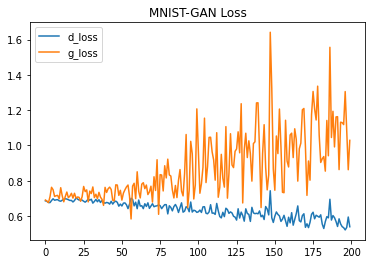

In [0]:
plt.plot(D_history, label='d_loss')
plt.plot(G_history, label='g_loss')
plt.title('MNIST-GAN Loss')
plt.legend()

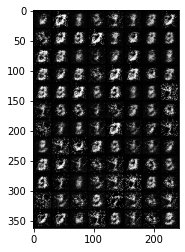

In [0]:
# Show generated images
epoch_1 = imread('gan_images/1.png')
plt.imshow(epoch_1)

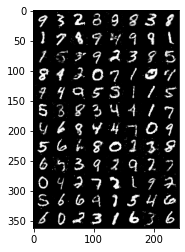

In [0]:
epoch_50 = imread('gan_images/50.png')
plt.imshow(epoch_50)

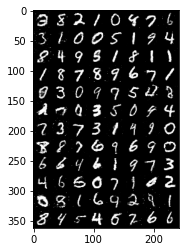

In [0]:
epoch_100 = imread('gan_images/100.png')
plt.imshow(epoch_100)

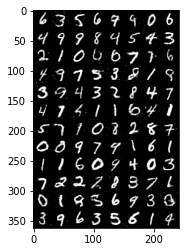

In [0]:
epoch_150 = imread('gan_images/150.png')
plt.imshow(epoch_150)

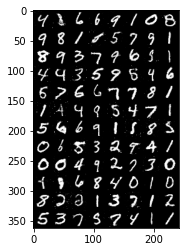

In [0]:
epoch_200 = imread('gan_images/200.png')
plt.imshow(epoch_200)